## Monthly Ward-Level Burglary Rate Prediction


In [20]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


### 1. Monthly Burglary Rate Calculation


In [21]:
# Load and preprocess burglary data
burglary = pd.read_csv('data/residential_burglary.csv')

# Ensure 'Month' column is a string and correctly formatted as YYYY-MM before conversion
burglary['Month'] = burglary['Month'].astype(str).str.zfill(2)
burglary['Full_Date'] = burglary['Year'].astype(str) + '-' + burglary['Month']
burglary['Month'] = pd.to_datetime(burglary['Full_Date'], format='%Y-%m')

# Extract year correctly
burglary['Year'] = burglary['Month'].dt.year
burglary['Month'] = burglary['Month'].dt.to_period('M')  # Convert to Period format for monthly aggregation

# Calculate monthly totals
monthly_totals = burglary.groupby('Month').size().reset_index(name='TotalBurglaries')

# Calculate ward-monthly rates
ward_monthly = burglary.groupby(['Ward Code', 'Month']).size().reset_index(name='WardBurglaries')
ward_monthly = ward_monthly.merge(monthly_totals, on='Month', how='left')
ward_monthly['BurglaryRate'] = (ward_monthly['WardBurglaries'] / ward_monthly['TotalBurglaries']) * 100

# Create complete date range
min_date = ward_monthly['Month'].min()
max_date = ward_monthly['Month'].max()
all_months = pd.period_range(start=min_date, end=max_date, freq='M')

# Get unique wards
all_wards = ward_monthly['Ward Code'].unique()

# Create complete index
index = pd.MultiIndex.from_product([all_wards, all_months], names=['Ward Code', 'Month'])

# Set index, fill missing values
ward_monthly = ward_monthly.set_index(['Ward Code', 'Month']).reindex(index, fill_value=0).reset_index()

# Ensure BurglaryRate column handles missing values properly
ward_monthly['BurglaryRate'] = ward_monthly['BurglaryRate'].fillna(0)

# Display processed data
ward_monthly


,Ward Code,Month,WardBurglaries,TotalBurglaries,BurglaryRate
0,E05009317,2013-12,8,7018,0.113993
1,E05009317,2014-01,23,7233,0.317987
2,E05009317,2014-02,12,6221,0.192895
3,E05009317,2014-03,11,6179,0.178022
4,E05009317,2014-04,21,5418,0.387597
...,...,...,...,...,...
91660,E05014119,2024-10,1,4005,0.024969
91661,E05014119,2024-11,2,4073,0.049104
91662,E05014119,2024-12,4,4211,0.094989
91663,E05014119,2025-01,3,3913,0.076668


### 2. Feature Engineering with Temporal Alignment


In [22]:
# Load IMD 2019 data
imd = pd.read_excel('data/imd2019_wards.xlsx', usecols=[
    'Ward Code', 'IMD average score',
    'IDACI score', 'IDAOPI score'
]).drop_duplicates('Ward Code')

imd = imd[imd["Ward Code"] != "E05009297"]

# Load Housing Factors 2021 data
cars = pd.read_excel('data/housing/cars_or_vans_wards.xlsx', sheet_name='2021')
cars = cars[cars["ward code"] != "E09000001"]
cars = cars.assign(
    pct_no_car=cars['none']/cars['All households '],
    pct_one_car=cars['one']/cars['All households '],
    pct_two_cars=cars['two']/cars['All households ']
)[['ward code', 'pct_no_car', 'pct_one_car', 'pct_two_cars']]

occupancy = pd.read_excel('data/housing/occupancy_rating_bedrooms_wards.xlsx', sheet_name='2021')
occupancy = occupancy[occupancy["ward code"] != "E09000001"]
occupancy = occupancy.assign(
    pct_plus2=occupancy['Occupancy rating: +2 or more']/occupancy['All Households'],
    pct_plus1=occupancy['+1']/occupancy['All Households'],
    pct_zero=occupancy['0']/occupancy['All Households']
)[['ward code', 'pct_plus2', 'pct_plus1', 'pct_zero']]

features_2021 = cars.merge(occupancy, on='ward code').rename(columns={'ward code': 'Ward Code'})

features_2021


,Ward Code,pct_no_car,pct_one_car,pct_two_cars,pct_plus2,pct_plus1,pct_zero
0,E05014053,0.653820,0.283551,0.054370,0.070103,0.154639,0.518213
1,E05014054,0.324858,0.454083,0.174394,0.154630,0.292778,0.385975
2,E05014055,0.312592,0.524034,0.137128,0.099261,0.245495,0.470015
3,E05014056,0.333457,0.458318,0.164876,0.192379,0.273030,0.367000
4,E05014057,0.296031,0.458360,0.184450,0.147183,0.267665,0.398242
...,...,...,...,...,...,...,...
674,E05013805,0.626525,0.298143,0.059416,0.168348,0.297398,0.470349
675,E05013806,0.758674,0.192867,0.037798,0.107247,0.276277,0.559355
676,E05013807,0.687088,0.267352,0.040326,0.093230,0.276209,0.535203
677,E05013808,0.737813,0.205698,0.045619,0.112080,0.264483,0.554312


### 3. Temporal Feature Merging


In [23]:
def merge_features(df):
    # Add temporal features
    df['Year'] = df['Month'].dt.year
    df['MonthNum'] = df['Month'].dt.month

    # Merge IMD 2019 data
    df = df.merge(imd, on='Ward Code', how='left')

    # Merge 2021 features with forward fill
    df = df.merge(features_2021, on='Ward Code', how='left')

    # Create feature groups
    static_features = ['IMD average score', 'IDACI score', 'IDAOPI score']
    time_varying_features = ['pct_no_car', 'pct_one_car', 'pct_two_cars',
                             'pct_plus2', 'pct_plus1', 'pct_zero']

    # Forward fill time-varying features
    df[time_varying_features] = df.groupby('Ward Code')[time_varying_features].ffill()

    return df.drop(columns=['Year'])

# Merge features
final_data = merge_features(ward_monthly)

# Final cleaning
final_data = final_data.dropna(subset=['BurglaryRate'])
final_data = final_data.sort_values(['Ward Code', 'Month'])

final_data


,Ward Code,Month,WardBurglaries,TotalBurglaries,BurglaryRate,MonthNum,IMD average score,IDACI score,IDAOPI score,pct_no_car,pct_one_car,pct_two_cars,pct_plus2,pct_plus1,pct_zero
0,E05009317,2013-12,8,7018,0.113993,12,29.674838,0.28001,0.424114,0.632145,0.318182,0.042733,0.083220,0.237327,0.484684
1,E05009317,2014-01,23,7233,0.317987,1,29.674838,0.28001,0.424114,0.632145,0.318182,0.042733,0.083220,0.237327,0.484684
2,E05009317,2014-02,12,6221,0.192895,2,29.674838,0.28001,0.424114,0.632145,0.318182,0.042733,0.083220,0.237327,0.484684
3,E05009317,2014-03,11,6179,0.178022,3,29.674838,0.28001,0.424114,0.632145,0.318182,0.042733,0.083220,0.237327,0.484684
4,E05009317,2014-04,21,5418,0.387597,4,29.674838,0.28001,0.424114,0.632145,0.318182,0.042733,0.083220,0.237327,0.484684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91660,E05014119,2024-10,1,4005,0.024969,10,NaN,NaN,NaN,0.424795,0.462555,0.093350,0.287723,0.268835,0.368940
91661,E05014119,2024-11,2,4073,0.049104,11,NaN,NaN,NaN,0.424795,0.462555,0.093350,0.287723,0.268835,0.368940
91662,E05014119,2024-12,4,4211,0.094989,12,NaN,NaN,NaN,0.424795,0.462555,0.093350,0.287723,0.268835,0.368940
91663,E05014119,2025-01,3,3913,0.076668,1,NaN,NaN,NaN,0.424795,0.462555,0.093350,0.287723,0.268835,0.368940


### 4. Time-Based Validation Split


In [24]:
# Split data - use 2019-2020 as cutoff for COVID impact
train = final_data[final_data['Month'] < '2021-01']
test = final_data[final_data['Month'] >= '2021-01']

# Features and target
features = ['IMD average score', 'IDACI score', 'IDAOPI score',
            'pct_no_car', 'pct_one_car', 'pct_two_cars',
            'pct_plus2', 'pct_plus1', 'pct_zero', 'MonthNum']
target = 'BurglaryRate'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]


### 5. Model Training with Temporal Cross-Validation


In [25]:
# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Model pipeline
model = GridSearchCV(
    XGBRegressor(objective='reg:squarederror'),
    param_grid={
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1]
    },
    cv=tscv,
    scoring='neg_mean_squared_error'
)

model.fit(X_train, y_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

### 6. Model Evaluation


In [26]:
# Test set evaluation
test_pred = model.predict(X_test)
print("Test Performance:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, test_pred):.4f}")


Test Performance:
RMSE: 0.0969
MAE: 0.0737


### 7. Visualization of Burglary Rates


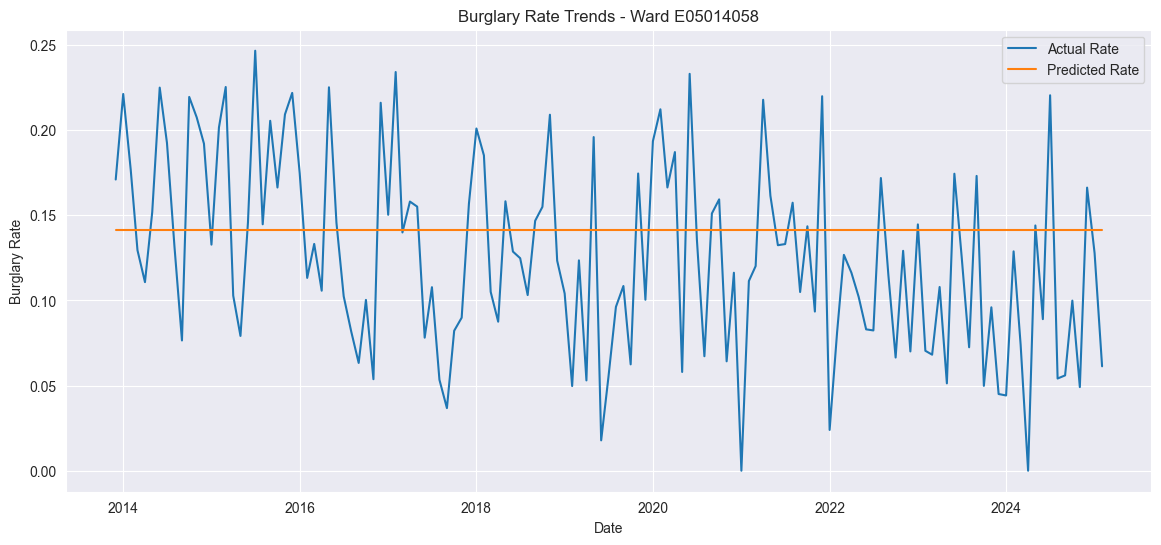

In [27]:
# Plot actual vs predicted rates for a sample ward
sample_ward = final_data[final_data['Ward Code'] == 'E05014058']

plt.figure(figsize=(14, 6))
plt.plot(sample_ward['Month'].astype('datetime64[ns]'),
         sample_ward['BurglaryRate'],
         label='Actual Rate')
plt.plot(sample_ward['Month'].astype('datetime64[ns]'),
         model.predict(sample_ward[features]),
         label='Predicted Rate')
plt.title('Burglary Rate Trends - Ward E05014058')
plt.xlabel('Date')
plt.ylabel('Burglary Rate')
plt.legend()
plt.grid(True)
plt.show()


### 8. Feature Importance Analysis


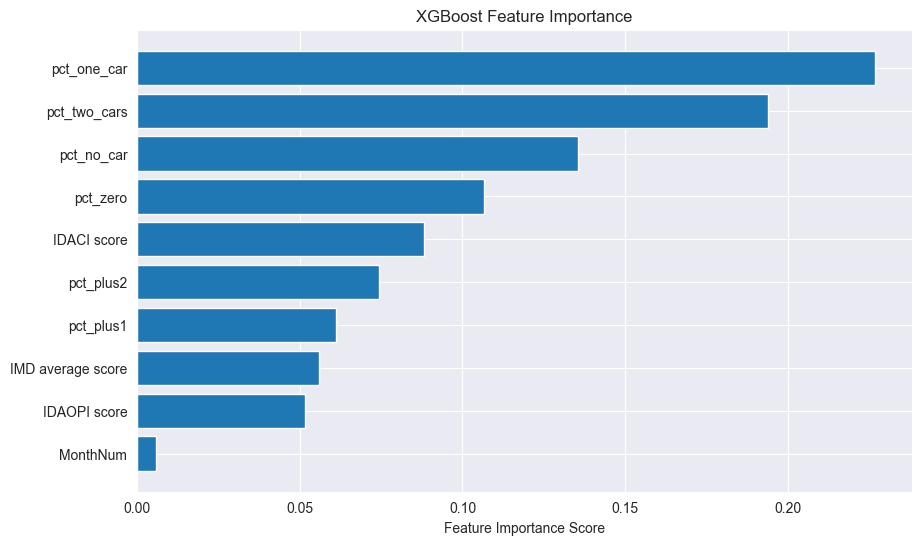

In [28]:
# Plot feature importance
best_model = model.best_estimator_
sorted_idx = best_model.feature_importances_.argsort()

plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx], best_model.feature_importances_[sorted_idx])
plt.xlabel('Feature Importance Score')
plt.title('XGBoost Feature Importance')
plt.show()


### 9. Future Rate Prediction (2026)


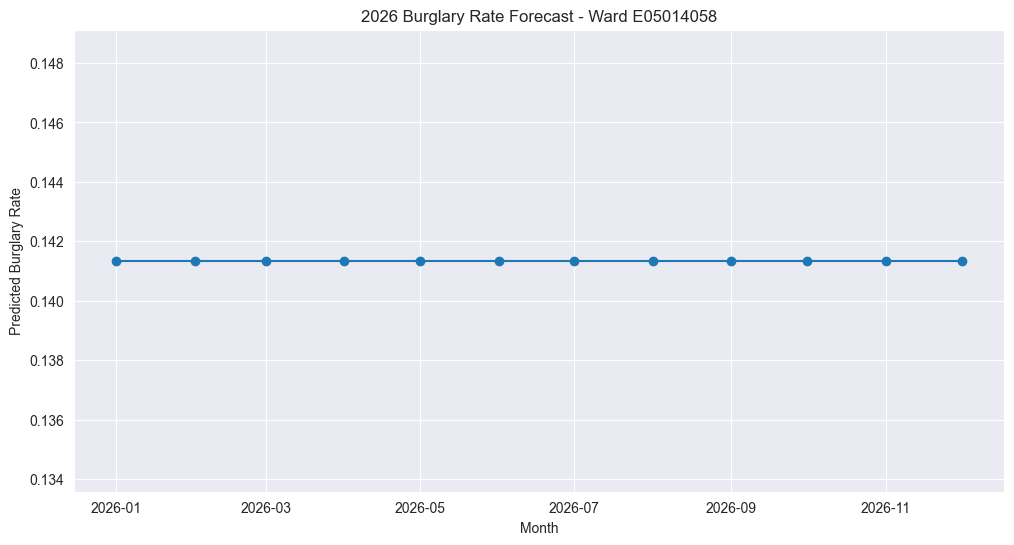

In [29]:
# Generate future dates
future_months = pd.period_range(start='2026-01', periods=12, freq='M')

# Create template dataframe
future_data = pd.DataFrame({
    'Ward Code': np.repeat('E05014058', 12),
'Month': future_months,
'MonthNum': future_months.month
})

# Merge features
future_data = merge_features(future_data)
future_data = future_data.ffill()  # Forward fill missing features

# Predict rates
future_rates = model.predict(future_data[features])

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_months.to_timestamp(), future_rates, marker='o')
plt.title('2026 Burglary Rate Forecast - Ward E05014058')
plt.xlabel('Month')
plt.ylabel('Predicted Burglary Rate')
plt.grid(True)
plt.show()